In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Ring-Moon Systems Node Web Analysis

In [17]:
import os
import sys
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

sys.path.append('../src')
from clf_data_augmenter import CLFDataAugmenter

In [18]:
%%time
#df_all = pd.read_feather('../datasets/rings_all.feather')
df_all = pd.read_feather('../datasets/rings_all_sm.feather')

CPU times: user 1.92 s, sys: 574 ms, total: 2.49 s
Wall time: 1.77 s


In [19]:
%%time
augmenter = CLFDataAugmenter(df_all)
augmenter.augment_data()
df_all = augmenter.get_df()

Data augmented? True
CPU times: user 46.2 s, sys: 657 ms, total: 46.9 s
Wall time: 46.9 s


In [20]:
print(df_all.dtypes)
df_all.head()

ip                         object
identd                     object
userid                     object
datetime      datetime64[ns, UTC]
request                    object
status                      int64
size                      float64
referer                    object
user_agent                 object
date               datetime64[ns]
month_year         datetime64[ns]
DOW                        object
hour                        int64
log_name                   object
req_type                   object
tool                       object
dtype: object


,ip,identd,userid,datetime,request,status,size,referer,user_agent,date,month_year,DOW,hour,log_name,req_type,tool
0,17.58.98.26,None,None,2021-01-01 00:01:09+00:00,GET /press_releases/thumbnails/PIA00xxx/PIA000...,200,1639.0,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5...,2021-01-01,2021-01-01,Friday,0,None,GET,content
1,13.66.139.53,None,None,2021-01-01 00:01:27+00:00,GET /press_releases/medium/PIA13xxx/PIA13294_m...,200,46938.0,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,2021-01-01,2021-01-01,Friday,0,None,GET,content
2,66.249.79.94,None,None,2021-01-01 00:01:30+00:00,GET /pds4/bundles/cassini_vims_cruise/browse_r...,200,2515.0,None,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,2021-01-01,2021-01-01,Friday,0,None,GET,content
3,207.241.233.164,None,None,2021-01-01 00:01:47+00:00,GET /viewmaster/volumes/COISS_1xxx/COISS_1002/...,200,36171.0,https://pds-rings.seti.org/viewmaster/volumes/...,Mozilla/5.0 (compatible; archive.org_bot +http...,2021-01-01,2021-01-01,Friday,0,None,GET,viewmaster
4,10.1.6.151,None,None,2021-01-01 00:01:52+00:00,GET / HTTP/1.1,200,19358.0,None,Zabbix,2021-01-01,2021-01-01,Friday,0,None,GET,content


## Intro and Overall Node Characteristics.
Overall traffic utilization since 2017. Log data consists of 2539 files containing approximately 110M log entries for about 28GB of total data.

Typically, this node shows low levels of traffic and typically serves between 100 MB-1GB of data on a daily basis. This accounts for roughly 95% of the days. On occasion, there are days where requests increase significantly (500GB).

In [24]:
df_summary = (
    df_all.loc[(df_all.req_type == "GET") & (df_all.status == 200)].
    groupby(by='date').aggregate({'size': 'sum', 'ip': 'count'}).
    rename(columns={'size': 'data_transmit (GB/day)', 'ip': 'GET requests (hits/day)'}).
    reset_index()
)

# Should give us GB/day
df_summary['data_transmit (GB/day)'] = df_summary['data_transmit (GB/day)'] / 2**30
df_summary['data_transmit_range'] = pd.cut(df_summary['data_transmit (GB/day)'], 
                                       bins=[0, .1, 1, 10, 100, 200, 500, 1000, 100000],
                                       labels=['0-100MB', '100MB-1GB', '1-10GB', '10-100GB', '100-200GB', '200-500GB', 
                                               '500GB-1TB', '>1TB'])

In [26]:
df_summary.head()

,date,data_transmit (GB/day),GET requests (hits/day),data_transmit_range
0,2021-01-01,3.263697,7722,1-10GB
1,2021-01-02,18.272445,32888,10-100GB
2,2021-01-03,20.967912,19506,10-100GB
3,2021-01-04,9.173573,25310,1-10GB
4,2021-01-05,5.024932,12864,1-10GB


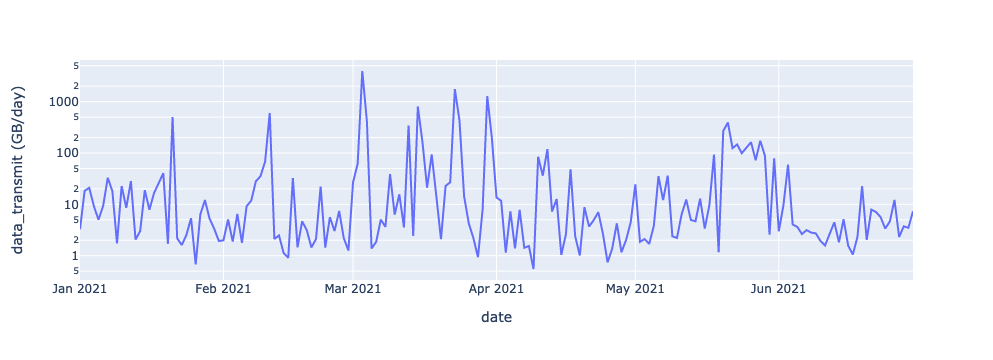

In [27]:
# Overall Node Transmit rate
df_summary.sort_values(by='date', inplace=True)
fig = px.line(df_summary, x="date", y="data_transmit (GB/day)", log_y=True)
fig.show()

  data_transmit_range  count
0             0-100MB      0
1           100MB-1GB      5
2              1-10GB    110
3            10-100GB     47
4           100-200GB      8
5           200-500GB      5
6           500GB-1TB      3
7                >1TB      3


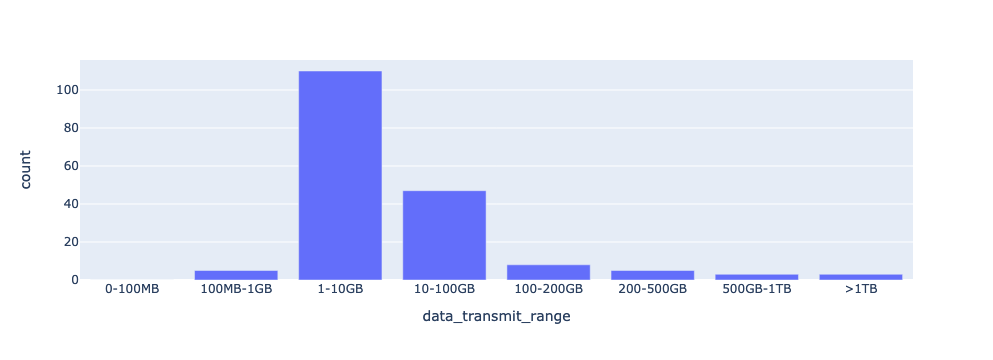

In [32]:
df_plot = df_summary.groupby(by='data_transmit_range').size().to_frame('count').reset_index() 
print(df_pie)
# fig = px.pie(df_pie, values='count', names='data_transmit_range', sort=True)
fig = px.bar(df_plot, x='data_transmit_range', y='count')
fig.show()